# PSyKE's demo for regression tasks

Some imports.

In [1]:
from psyke import Extractor
from psyke.optimizer.pedro import PEDRO
from psyke.optimizer import Objective
from psyke.optimizer.crash import CRASH
from sklearn.neighbors import KNeighborsRegressor
from psyke.utils.logic import pretty_theory
from sklearn.model_selection import train_test_split
from psyke.utils import Target
from matplotlib import pyplot as plt
import pandas as pd

Import an artificial dataset.

In [2]:
dataset = pd.read_csv("../test/resources/datasets/df.csv")
#dataset = pd.read_csv("test/resources/datasets/CCPP.csv", sep=";", decimal=",")
#dataset

Split between train and test set in a reproducible way.

In [3]:
dataset = dataset[["X", "Y", "Z4"]].dropna()
train, test = train_test_split(dataset, test_size=0.5, random_state=10)

We use as predictor a KNN and we train it.

In [4]:
predictor = KNeighborsRegressor(n_neighbors=3).fit(train.iloc[:, :-1], train.iloc[:, -1])

print(f'{(abs(predictor.predict(test.iloc[:, :-1]).flatten() - test.iloc[:, -1])).mean():.2f}')

0.03688944007870007


We create several extractors that use ITER, GridEx and GridREx algorithms to extract prolog rules from the predictor.

In [5]:
creepy = Extractor.creepy(predictor, depth=3, error_threshold=0.02, output=Target.REGRESSION)
theory_from_creepy = creepy.extract(train)
print('CReEPy performance ({} rules):\nMAE = {:.2f}\nMAE fidelity = {:.2f}\n'
      .format(creepy.n_rules, creepy.mae(test), creepy.mae(test, predictor)))
print('CReEPy extracted rules:\n\n' + pretty_theory(theory_from_creepy))

CReEPy performance (4 rules):
MAE = 0.42
MAE fidelity = 0.43

CReEPy extracted rules:

'Z4'(X, Y, Z4) :-
    X in [0.15, 0.59], Y in [0.15, 0.59], Z4 is 12.22 + -15.46 * X + 8.44 * Y.
'Z4'(X, Y, Z4) :-
    X in [0.15, 0.84], Y in [-0.00, 0.59], Z4 is 2.07 + 2.62 * X + 5.92 * Y.
'Z4'(X, Y, Z4) :-
    X in [0.15, 0.84], Y in [-0.00, 0.84], Z4 is 9.01 + -11.99 * X + 14.97 * Y.
'Z4'(X, Y, Z4) :-
    X in [-0.00, 1.00], Y in [-0.00, 1.00], Z4 is 1.99 + 3.99 * X + -2.99 * Y.


In [6]:
orchid = Extractor.orchid(predictor, depth=2, error_threshold=0.02, output=Target.REGRESSION)
theory_from_orchid = orchid.extract(train)
print('ORCHiD performance ({} rules):\nMAE = {:.2f}\nMAE fidelity = {:.2f}\n'
      .format(orchid.n_rules, orchid.mae(test), orchid.mae(test, predictor)))
print('ORCHiD extracted rules:\n\n' + pretty_theory(theory_from_orchid))

ORCHiD performance (3 rules):
MAE = 0.68
MAE fidelity = 0.69

ORCHiD extracted rules:

'Z4'(X, Y, Z4) :-
    X in [0.15, 0.84], Y in [-0.00, 0.59], Z4 is 7.49 + -7.63 * X + 12.04 * Y.
'Z4'(X, Y, Z4) :-
    X in [0.15, 0.84], Y in [-0.00, 0.84], Z4 is 9.01 + -11.99 * X + 14.97 * Y.
'Z4'(X, Y, Z4) :-
    X in [-0.00, 1.00], Y in [-0.00, 1.00], Z4 is 1.99 + 3.99 * X + -2.99 * Y.


Algorithm.CReEPy. Depth: 1. Threshold = 0.02. MAE = 0.35, 2 rules
Algorithm.CReEPy. Depth: 1. Threshold = 0.04. MAE = 0.35, 2 rules
Algorithm.CReEPy. Depth: 1. Threshold = 0.35. MAE = 0.35, 2 rules

Algorithm.CReEPy. Depth: 2. Threshold = 0.02. MAE = 0.03, 3 rules
Algorithm.CReEPy. Depth: 2. Threshold = 0.04. MAE = 0.03, 3 rules
Algorithm.CReEPy. Depth: 2. Threshold = 0.05. MAE = 0.03, 3 rules

**********************
Best Algorithm.CReEPy
**********************
MAE = 0.03, 3 rules
Threshold = 0.02
Depth = 2

**********************
Best   MAE  
**********************
MAE = 0.03, 3 rules
Threshold = 0.02
Depth = 2

**********************
Best N rules
**********************
MAE = 0.35, 2 rules
Threshold = 0.02
Depth = 1

CReEPy performance (3 rules):
MAE = 0.68
MAE fidelity = 0.69



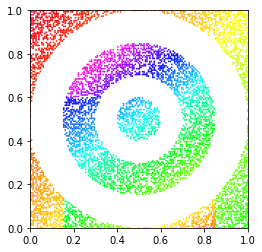

In [7]:
crash = CRASH(predictor, train, max_depth=5, patience=2, readability_tradeoff=.5,
              algorithm=CRASH.Algorithm.CReEPy, output=Target.REGRESSION)
crash.search()
(_, _, depth, threshold) = crash.get_best()[0]

creepy = Extractor.creepy(predictor, depth=depth, error_threshold=threshold, output=Target.REGRESSION)
theory_from_creepy = creepy.extract(train)
print('CReEPy performance ({} rules):\nMAE = {:.2f}\nMAE fidelity = {:.2f}\n'
      .format(creepy.n_rules, creepy.mae(test), creepy.mae(test, predictor)))
#print('CReEPy extracted rules:\n\n' + pretty_theory(theory_from_cream))

plt.scatter(test.X, test.Y, c=creepy.predict(test.iloc[:, :-1]), s=0.5, cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.gca().set_aspect("equal")
plt.show()

Algorithm.ORCHiD. Depth: 1. Threshold = 0.02. MAE = 2.64, 2 rules
Algorithm.ORCHiD. Depth: 1. Threshold = 0.04. MAE = 2.64, 2 rules
Algorithm.ORCHiD. Depth: 1. Threshold = 2.64. MAE = 2.64, 2 rules

Algorithm.ORCHiD. Depth: 2. Threshold = 0.02. MAE = 2.38, 4 rules
Algorithm.ORCHiD. Depth: 2. Threshold = 0.04. MAE = 2.38, 4 rules
Algorithm.ORCHiD. Depth: 2. Threshold = 2.38. MAE = 2.61, 3 rules
Algorithm.ORCHiD. Depth: 2. Threshold = 4.73. MAE = 2.64, 2 rules
Algorithm.ORCHiD. Depth: 2. Threshold = 7.08. MAE = 2.64, 2 rules

Algorithm.ORCHiD. Depth: 3. Threshold = 0.02. MAE = 1.40, 8 rules
Algorithm.ORCHiD. Depth: 3. Threshold = 0.04. MAE = 1.40, 8 rules
Algorithm.ORCHiD. Depth: 3. Threshold = 1.40. MAE = 1.75, 6 rules

**********************
Best Algorithm.ORCHiD
**********************
MAE = 2.38, 4 rules
Threshold = 0.02
Depth = 2

**********************
Best   MAE  
**********************
MAE = 1.40, 8 rules
Threshold = 0.02
Depth = 3

**********************
Best N rules
************

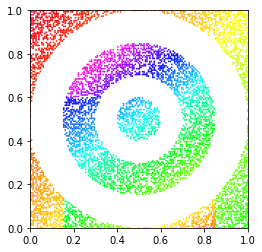

In [8]:
crash = CRASH(predictor, train, max_depth=5, patience=2, readability_tradeoff=.75, algorithm=CRASH.Algorithm.ORCHiD)
crash.search()
(_, _, depth, threshold) = crash.get_best()[0]

orchid = Extractor.orchid(predictor, depth=depth, error_threshold=threshold, output=Target.REGRESSION)
theory_from_orchid = orchid.extract(train)
print('ORCHiD performance ({} rules):\nMAE = {:.2f}\nMAE fidelity = {:.2f}\n'
      .format(orchid.n_rules, orchid.mae(test), orchid.mae(test, predictor)))
print('ORCHiD extracted rules:\n\n' + pretty_theory(theory_from_orchid))

plt.scatter(test.X, test.Y, c = orchid.predict(test.iloc[:, :-1]), s = 0.5, cmap=plt.cm.get_cmap('gist_rainbow'))
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.gca().set_aspect("equal")
plt.show()

In [9]:
it = Extractor.iter(predictor, min_update=1.0 / 20, n_points=1, max_iterations=600,
                    min_examples=100, threshold=1.5)
theory_from_iter = it.extract(train)
print('ITER performance ({} rules):\nMAE = {:.2f}\nMAE fidelity = {:.2f}\n'
      .format(it.n_rules, it.mae(test), it.mae(test, predictor)))
print('ITER extracted rules:\n\n' + pretty_theory(theory_from_iter))

ITER performance (54 rules):
MAE = 0.81
MAE fidelity = 0.81

ITER extracted rules:

'Z4'(X, Y, 9.13) :-
    X in [0.63, 0.88], Y in [0.49, 0.69].
'Z4'(X, Y, 11.07) :-
    X in [0.63, 0.88], Y in [0.69, 0.79].
'Z4'(X, Y, 6.92) :-
    X in [0.63, 0.88], Y in [0.34, 0.49].
'Z4'(X, Y, 5.20) :-
    X in [0.63, 1.00], Y in [-0.00, 0.34].
'Z4'(X, Y, 5.21) :-
    X in [0.88, 1.00], Y in [0.34, 0.49].
'Z4'(X, Y, 8.62) :-
    X in [0.63, 0.88], Y in [0.79, 0.84].
'Z4'(X, Y, 11.58) :-
    X in [0.53, 0.63], Y in [0.49, 0.69].
'Z4'(X, Y, 7.76) :-
    X in [0.48, 0.53], Y in [0.49, 0.69].
'Z4'(X, Y, 6.16) :-
    X in [0.38, 0.48], Y in [0.49, 0.69].
'Z4'(X, Y, 5.43) :-
    X in [0.63, 0.88], Y in [0.84, 0.89].
'Z4'(X, Y, 3.03) :-
    X in [0.88, 1.00], Y in [0.84, 1.00].
'Z4'(X, Y, 2.49) :-
    X in [0.63, 0.88], Y in [0.89, 1.00].
'Z4'(X, Y, 5.37) :-
    X in [0.88, 1.00], Y in [0.49, 0.69].
'Z4'(X, Y, 3.17) :-
    X in [0.88, 1.00], Y in [0.79, 0.84].
'Z4'(X, Y, 11.25) :-
    X in [0.33, 0.38], Y

In [10]:
pedro = PEDRO(predictor, train, max_mae_increase=1.2, min_rule_decrease=0.9, readability_tradeoff=0.1,
              max_depth=5, patience=3, algorithm=PEDRO.Algorithm.GRIDEX, objective=Objective.MODEL)
pedro.search()
(_, _, threshold, grid) = pedro.get_best()[0]

gridEx = Extractor.gridex(predictor, grid, threshold=threshold)
theory_from_gridEx = gridEx.extract(train)
print('GridEx performance ({} rules):\nMAE = {:.2f}\nMAE fidelity = {:.2f}\n'
      .format(gridEx.n_rules, gridEx.mae(test), gridEx.mae(test, predictor)))
print('GridEx extracted rules:\n\n' + pretty_theory(theory_from_gridEx))

Algorithm.GRIDEX. Grid (1). Fixed (2). Threshold = 0.01. MAE = 4.04, 4 rules
Algorithm.GRIDEX. Grid (1). Fixed (2). Threshold = 0.03. MAE = 4.04, 4 rules
Algorithm.GRIDEX. Grid (1). Fixed (2). Threshold = 2.03. MAE = 4.04, 4 rules
Algorithm.GRIDEX. Grid (1). Fixed (2). Threshold = 4.04. MAE = 4.07, 3 rules
Algorithm.GRIDEX. Grid (1). Fixed (2). Threshold = 6.05. MAE = 4.07, 3 rules
Algorithm.GRIDEX. Grid (1). Fixed (2). Threshold = 8.05. MAE = 4.19, 1 rules

Algorithm.GRIDEX. Grid (2). Fixed (2). Threshold = 0.01. MAE = 1.89, 16 rules
Algorithm.GRIDEX. Grid (2). Fixed (2). Threshold = 0.03. MAE = 1.89, 16 rules

Algorithm.GRIDEX. Grid (1). Fixed (3). Threshold = 0.01. MAE = 2.22, 9 rules
Algorithm.GRIDEX. Grid (1). Fixed (3). Threshold = 0.03. MAE = 2.22, 9 rules
Algorithm.GRIDEX. Grid (1). Fixed (3). Threshold = 1.13. MAE = 2.22, 9 rules
Algorithm.GRIDEX. Grid (1). Fixed (3). Threshold = 2.22. MAE = 2.27, 8 rules
Algorithm.GRIDEX. Grid (1). Fixed (3). Threshold = 3.32. MAE = 2.40, 7 r

In [11]:
pedro = PEDRO(predictor, train, max_mae_increase=1.2, min_rule_decrease=0.9, readability_tradeoff=0.1,
              max_depth=5, patience=3, algorithm=PEDRO.Algorithm.GRIDREX, objective=Objective.MODEL)
pedro.search()
(_, _, threshold, grid) = pedro.get_best()[0]

gridREx = Extractor.gridrex(predictor, grid, threshold=threshold)
theory_from_gridREx = gridREx.extract(train)
print('GridREx performance ({} rules):\nMAE = {:.2f}\nMAE fidelity = {:.2f}\n'
      .format(gridREx.n_rules, gridREx.mae(test), gridREx.mae(test, predictor)))
print('GridREx extracted rules:\n\n' + pretty_theory(theory_from_gridREx))

Algorithm.GRIDREX. Grid (1). Fixed (2). Threshold = 0.01. MAE = 2.08, 4 rules
Algorithm.GRIDREX. Grid (1). Fixed (2). Threshold = 0.03. MAE = 2.08, 4 rules
Algorithm.GRIDREX. Grid (1). Fixed (2). Threshold = 1.05. MAE = 2.08, 4 rules
Algorithm.GRIDREX. Grid (1). Fixed (2). Threshold = 2.08. MAE = 2.38, 3 rules
Algorithm.GRIDREX. Grid (1). Fixed (2). Threshold = 3.10. MAE = 2.38, 3 rules
Algorithm.GRIDREX. Grid (1). Fixed (2). Threshold = 4.13. MAE = 2.38, 3 rules
Algorithm.GRIDREX. Grid (1). Fixed (2). Threshold = 5.87. MAE = 4.18, 1 rules

Algorithm.GRIDREX. Grid (2). Fixed (2). Threshold = 0.01. MAE = 0.59, 16 rules
Algorithm.GRIDREX. Grid (2). Fixed (2). Threshold = 0.03. MAE = 0.59, 16 rules

Algorithm.GRIDREX. Grid (1). Fixed (3). Threshold = 0.01. MAE = 1.32, 9 rules
Algorithm.GRIDREX. Grid (1). Fixed (3). Threshold = 0.03. MAE = 1.32, 9 rules
Algorithm.GRIDREX. Grid (1). Fixed (3). Threshold = 0.67. MAE = 1.32, 9 rules
Algorithm.GRIDREX. Grid (1). Fixed (3). Threshold = 1.32. MA